Pip Install all Packages via Terminal in the Correct activated VENV
OR !pip install package below

For local installs: source SPR24ENV/bin/activate 
For cluster installs: source UNETvenv/bin/activate 

In [32]:
import tensorflow as tf # Ensure using 2.13.0 as mentioned

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available; TensorFlow is using CPU")

GPU is available


In [33]:
import os
import sys
import numpy as np
import datetime
import cv2  # opencv+python == 4.9.0.80 # image processing
import matplotlib.pyplot as plt
import hdf5storage  # 0.1.19

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# tf.keras specifically tailored to work with TensorFlow's backend seamlessly -> better compatibility/performance vs standalone keras
import tensorflow as tf  # Ensure using 2.13.0 as mentioned
from tensorflow.keras import backend as K # make sure all K are capital
from tensorflow.keras.models import Model  # Import specific classes
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam  # import specific optimizers
from tensorflow.keras.optimizers.legacy import Adam # trying legacy Adam for better performance
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler

Data Loading

In [34]:
path = '/Users/elizabethnemeti/Desktop/' # local runs
data_dir = os.path.join(path, 'data') # local runs
# data_dir = '/mnt/beegfs/labs/mahmoudilab/nemeti/UNET_tests/data' # cluster runs

if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"No such directory: {data_dir}")

files = os.listdir(data_dir)
print(f"Files in {data_dir}:", files) # should see the 3064 mat files

Files in /Users/elizabethnemeti/Desktop/data: ['259.mat', '1915.mat', '1901.mat', '265.mat', '1929.mat', '1097.mat', '503.mat', '517.mat', '1083.mat', '271.mat', '2207.mat', '2561.mat', '1068.mat', '2575.mat', '2213.mat', '1732.mat', '1054.mat', '2549.mat', '1040.mat', '1726.mat', '2978.mat', '729.mat', '701.mat', '1295.mat', '2944.mat', '2950.mat', '2788.mat', '1281.mat', '715.mat', '926.mat', '2763.mat', '2005.mat', '1518.mat', '2011.mat', '2777.mat', '932.mat', '2987.mat', '1256.mat', '1530.mat', '2039.mat', '1524.mat', '1242.mat', '2993.mat', '891.mat', '649.mat', '885.mat', '2818.mat', '675.mat', '2830.mat', '113.mat', '1487.mat', '1493.mat', '107.mat', '2824.mat', '661.mat', '12.mat', '852.mat', '2617.mat', '2171.mat', '1478.mat', '2165.mat', '2603.mat', '846.mat', '1322.mat', '1444.mat', '2159.mat', '1450.mat', '1336.mat', '1861.mat', '1875.mat', '339.mat', '1685.mat', '311.mat', '477.mat', '463.mat', '2398.mat', '1849.mat', '305.mat', '1691.mat', '2373.mat', '2415.mat', '488.ma

Data Preprocessing Pipeline
- we want to normalize pixel values

In [35]:
def load_and_preprocess_data(data_dir, image_dimension=512):
    images = []
    masks = []
    labels = []
    files = os.listdir(data_dir)
    scaler = MinMaxScaler()

    for i, file in enumerate(files, start=1):
        try:
            # Load the .mat file
            mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0]
            
            # Resize image and mask
            image = cv2.resize(mat_file[2], dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_CUBIC)
            mask = cv2.resize(mat_file[4].astype('uint8'), dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_CUBIC)

            # Normalize the resized image using MinMaxScaler
            image = image.astype(np.float32).reshape(-1, 1)  # Flatten the image to fit the scaler input
            image = scaler.fit_transform(image).reshape(image_dimension, image_dimension)  # Reshape back after scaling

            # Append processed image and mask to their respective lists
            images.append(image) # appending the resized images to the variable of the initial images
            masks.append(mask.astype(bool)) # aka booleans only, is there a mask or not? 
            labels.append(int(mat_file[0]))  # fixing our labels because of the transpose 

            if i % 10 == 0:
                sys.stdout.write(f'\r[{i}/{len(files)}] images loaded: {i / float(len(files)) * 100:.1f} %')
                sys.stdout.flush()

        except Exception as e:
            print(f"Failed to process file {file}: {e}")
            
    print("\nFinished loading and processing data.")
    
    return np.array(images), np.array(masks), np.array(labels) #converting labels to numpy arrays

data_dir = '/Users/elizabethnemeti/Desktop/data' # local runs
# data_dir = '/mnt/beegfs/labs/mahmoudilab/nemeti/UNET_tests/data' # cluster runs
# add in cluster path here
image_dimension = 512
images, masks, labels = load_and_preprocess_data(data_dir, image_dimension)

[3060/3064] images loaded: 99.9 %
Finished loading and processing data.


Histogram Equalizer (method 1)
- improves the contrast in an image by stretching out the intensity range of the histogram
- cv2.equalizeHist function expects a single-channel image (grayscale) as input, and it must be of type uint8
- each pixel value gets x by 255
- why uint8? to cast as a type that is unassigned (no +/-), (common when working with image intensity)
- need the .0 bc equalizer spits out float, so to help it in 255.0)

Original: 
# image = cv2.equalizeHist((image * 255).astype(np.uint8))/255.0

Contrast Adjustment (alternative method)
- select one at a time

In [36]:
# Histogram Equalizer

equalized_images = [] # store the equalized images

for i, image in enumerate(images):
    uint8_image = (image * 255).astype(np.uint8)  # scale to 255 and convert to uint8
    equalized_image = cv2.equalizeHist(uint8_image) # enhance the image contrast
    equalized_image = equalized_image.astype(np.float32) / 255.0 # convert equalized image back to regular scale 0-1
    equalized_images.append(equalized_image) # add equalized images to empty list

    if (i + 1) % 100 == 0 or i == len(images) - 1: # progress bar
        print(f'Processed {i + 1}/{len(images)} images')

images = np.array(equalized_images) # convert to numpy array for later processing

# Contrast Adjustment (alternative method)
# alpha = 1.5
# beta = 10
# image = cv2.convertScaleAbs(image, alpha, beta)

Processed 100/3064 images
Processed 200/3064 images
Processed 300/3064 images
Processed 400/3064 images
Processed 500/3064 images
Processed 600/3064 images
Processed 700/3064 images
Processed 800/3064 images
Processed 900/3064 images
Processed 1000/3064 images
Processed 1100/3064 images
Processed 1200/3064 images
Processed 1300/3064 images
Processed 1400/3064 images
Processed 1500/3064 images
Processed 1600/3064 images
Processed 1700/3064 images
Processed 1800/3064 images
Processed 1900/3064 images
Processed 2000/3064 images
Processed 2100/3064 images
Processed 2200/3064 images
Processed 2300/3064 images
Processed 2400/3064 images
Processed 2500/3064 images
Processed 2600/3064 images
Processed 2700/3064 images
Processed 2800/3064 images
Processed 2900/3064 images
Processed 3000/3064 images
Processed 3064/3064 images


Contrast Adjustment (OR method 2)
- src = image
- alpha = contrast (remember alpha is multiplied by source) 
- beta = brightness (remember beta is added to source)
- convert = saturate the image
- increase brightness b > 0, decrease b < 0
- increase contrast a > 1 (cant multiply by 0!), or decrease a < 1

In [37]:
# saving locally (optional, but useful)
save_path = '/Users/elizabethnemeti/Desktop/UNET_preprocessed_files' # local runs
# save_path = '/mnt/beegfs/labs/mahmoudilab/nemeti/UNET_tests/UNET_preprocessed_files' # cluster runs
np.save(os.path.join(save_path, 'labels.npy'), labels)
np.save(os.path.join(save_path, 'images.npy'), images)
np.save(os.path.join(save_path, 'masks.npy'), masks)

Splitting the dataset into Training, Validation and Test Set

- Split Training and Testing Data -> 80:20 split
- Split Test Set for Validation -> 
    - split test set into 2 EQUAL parts to get cross-validation set and final test set
    - each represents 10% of original data

In [38]:
# Testing and Training Split -> 80:20
images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)

# Cross Validation Split -> 2 equal parts each 10%
images_test, images_val, masks_test, masks_val = train_test_split(images_test,masks_test,test_size = 0.5,train_size =0.5,random_state=1)

print ("number of training examples = " + str(images_train.shape[0]))
print ("number of test examples = " + str(images_test.shape[0]))
print ("number of validation examples = " + str(images_val.shape[0]))
print ("Images_train shape: " + str(images_train.shape))
print ("Masks_train shape: " + str(masks_train.shape))
print ("Images_test shape: " + str(images_test.shape))
print ("Masks_test shape: " + str(masks_test.shape))
print ("Images_val shape: " + str(images_val.shape))
print ("Masks_val shape: " + str(masks_val.shape))

number of training examples = 2451
number of test examples = 306
number of validation examples = 307
Images_train shape: (2451, 512, 512)
Masks_train shape: (2451, 512, 512)
Images_test shape: (306, 512, 512)
Masks_test shape: (306, 512, 512)
Images_val shape: (307, 512, 512)
Masks_val shape: (307, 512, 512)


Define Coefficients and Loss Functions

Dice coef -> calculates the overlap between the predicted and true masks in segmentation
Dice loss -> minimize difference between the predicted and true masks
BCE (+ Dice loss) -> measures distance between actual and predicted probabilities; leverages both pixel-wise losses and region-based losses, promoting better segmentation results
Jaccard coeff -> measures similarity/diversity between predicted and true masks (0-1 val again)
Jaccard loss -> minimize loss
Focal -> loss function that addresses class imbalance by giving more weight to hard-to-classify examples

- For loss functions like BCE loss, Jaccard loss, and Focal loss, you want to monitor the loss itself ('BCE_loss', 'Jaccard_loss', or 'Focal_loss') because you want to minimize it
- For coefficients -> you're looking to maximize you would monitor 'Dice_coef' or 'Jaccard_coef'

In [39]:
smooth = 0.00001 # just good practice to avoid division by zero and stabilize the calculation by adding a super small number
    
def Dice_coef(y_true, y_pred):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))  # Ensuring the type is float32
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth) # val between 0 & 1, 1 means perfect agreement between predicted and true masks

def Dice_loss(y_true, y_pred):
    return 1.-Dice_coef(y_true, y_pred)


def BCE_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + Dice_loss(y_true, y_pred)


def Jaccard_coef(y_true, y_predicted): # true and predicted binary mask (function that maps bit image into 0 and 1 pixel values)
    intersection = K.sum(y_true*y_predicted, axis=[2, -1, -2]) # K.sum for element wise multiplication, over what axis will the intersection be mapped
    sum_union = K.sum(y_true+y_predicted, axis=[2, -1, -2]) # union so addition
    JC = (intersection+smooth)/(sum_union-intersection+smooth) # formula for Jaccard coeff, but added smooth to prevent division by a zero!
    return K.mean(JC) # return mean of Jaccard coefs (mean for the whole image dataset, 50 pics? 50 JC coeffs -> take mean to get 1)

def Jaccard_loss(y_true, y_predicted):
    return 1-Jaccard_coef(y_true, y_predicted) # make sure not JC!! bc that's inside the other func
        

def Focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred)) # pt is probability
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

UNET Model Architecture

- defined the model's structure, how it should compile, including what optimizer, loss function, and metrics to use
- choose one loss function at a time and comment out the others PER RUN
- change if needs improvement: activation functions
- change if needs improvement: sigmoid for binary, check if should change to multiclass (softmax) 
- change if needs improvement: Adam optimizer with a learning rate of 1e-2 open

In [40]:
def unet(input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9) 

    model = Model(inputs = inputs, outputs = conv10)

    model.summary()
    return model # should return UNcompiled model

Standard Training
- save the model with the best validation (development) accuracy until now
- a checkpoint saves the model's current state, including its weights, so we can resume training later/ use model from a particular epoch
- have different checks for different loss functions/metrics
- might need to use legacy version of Adam optimizer located at tf.keras.optimizers.legacy.Adam if too slow training times

Profiling Training
- WRITE IN command line: tensorboard --logdir logs/fit
- creates web page to view metrics
- Performance profiling includes measuring time the model spends on CPU/GPU/how the time is distributed across different operations
- useful to diagnose bottlenecks in the model

In [41]:
# 1. Initialize model
model = unet() 
print(model.summary()) # how many parameters? is architecture correct?

# 2. Compile model with selected metric/loss
model.compile(optimizer=Adam(learning_rate=1e-2), loss=Dice_loss, metrics=[Dice_coef]) # Dice
# model.compile(optimizer = Adam(learning_rate = 1e-2), loss=BCE_loss, metrics=[Dice_coef]) # BCE
# model.compile(optimizer=Adam(learning_rate=1e-2), loss=Jaccard_loss, metrics=[Jaccard_coef]) # Jaccard
# model.compile(optimizer=Adam(learning_rate=1e-2), loss=Focal_loss, metrics=[Dice_coef]) # Focal

# 3. Define checkpoint
metric_name = 'Dice_loss'  # metric we want to track - can change this accordingly

checkpoint = ModelCheckpoint(
    filepath="models/cnn-parameters-improvement-{epoch:02d}-{Dice_coef:.2f}.model",  # Adjusted filepath
    monitor=f'val_{metric_name}',  # Monitor the validation metric
    verbose=1,
    save_best_only=True,
    mode='min' # set as 'min' for losses, 'max' for coefs
)

print(f"Checkpoint will save the model at: {filepath}, monitoring '{metric_name}' for improvements.")

# 4. Set up TensorBoard callback for profiling
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # logs to be written here, appends tcurrent date/time
#tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='10,20') # freq 1=histograms logged after every epoch; profiles 10th to 20th batch of every epoch

# 5. Train model 
model.fit(
    images_train, masks_train,
    batch_size=2,
    epochs=1, # was 30, 5 for test # 1 for test
    verbose=1, #verbose 1 or 2 to see outputs better
    validation_data=(images_val, masks_val),
    callbacks=[checkpoint] 
    #callbacks=[checkpoint, tensorboard_callback] # add tensorboard_callback here for profiling
)

# 6. Save model
model.save('first_trained_model.h5')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_72 (Conv2D)          (None, 512, 512, 64)         640       ['input_4[0][0]']             
                                                                                                  
 conv2d_73 (Conv2D)          (None, 512, 512, 64)         36928     ['conv2d_72[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 256, 256, 64)         0         ['conv2d_73[0][0]']           
 ng2D)                                                                                      

2024-04-15 13:10:51.659967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1226/1226 [==============================] - ETA: 0s - loss: 0.9669 - Dice_coef: 0.0332

2024-04-15 13:28:15.873941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1226/1226 [==============================] - 1085s 884ms/step - loss: 0.9669 - Dice_coef: 0.0332 - val_loss: 0.9673 - val_Dice_coef: 0.0327


/Users/elizabethnemeti/UNETENV/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Optional Training with Data augmentation
- for generalizability, to potentially help the accuracy score
- if using this data augmentation code block, comment OUT unaugmented training block

Dimension issue:
images_train.shape[0]: original batch size --> Batch size: number of images processed in a single batch
images_train.shape[1]: original height --> Height: vertical size of the images
images_train.shape[2]: original width --> Width: horizontal size of the images
1: Adding single channel dimension for grayscale --> Channels: depth of the image, 1 for grayscale, 3 for RGB color images

Batch size: The number of images processed in a single batch.
Height: The vertical size of the images.
Width: The horizontal size of the images.
Channels: The depth of the image, e.g., 1 for grayscale images, 3 for RGB color images.

# was missing channels dimension (rank 4), adding it back as 1
if images_train.ndim == 3: # check if array is 3-dimensional
    images_train = images_train.reshape(images_train.shape[0], images_train.shape[1], images_train.shape[2], 1) # reshape array +1 dimension
if masks_train.ndim == 3:
    masks_train = masks_train.reshape(masks_train.shape[0], masks_train.shape[1], masks_train.shape[2], 1)
if images_val.ndim == 3:
    images_val = images_val.reshape(images_val.shape[0], images_val.shape[1], images_val.shape[2], 1)
if masks_val.ndim == 3:
    masks_val = masks_val.reshape(masks_val.shape[0], masks_val.shape[1], masks_val.shape[2], 1)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 1. Initialize model
model = unet() 
print(model.summary()) 

# 2. Compile model with selected metric/loss
model.compile(optimizer=Adam(learning_rate=1e-2), loss=Dice_loss, metrics=[Dice_coef]) # Dice
# model.compile(optimizer = Adam(learning_rate = 1e-2), loss=BCE_loss, metrics=[Dice_coef]) # BCE
# model.compile(optimizer=Adam(learning_rate=1e-2), loss=Jaccard_loss, metrics=[Jaccard_coef]) # Jaccard
# model.compile(optimizer=Adam(learning_rate=1e-2), loss=Focal_loss, metrics=[Dice_coef]) # Focal

# 3. Define checkpoint
filepath = "models/cnn-parameters-improvement-{epoch:02d}-{Dice_coef:.2f}.model"  # Adjust 'dice_coef' if monitoring a different metric
checkpoint = ModelCheckpoint(filepath, monitor='Dice_coef', verbose=1, save_best_only=True, mode='max')
print(f"Checkpoint will save data augmented model at: {filepath}, monitoring '{checkpoint.monitor}' for improvements.")

# 4. Train model using training data generator
model.fit(datagen.flow(images_train, masks_train, batch_size=2), epochs=30, verbose=1, validation_data=(images_val, masks_val), callbacks=[checkpoint])

# 5. Save model
model.save('first_data_augmented_trained_model.h5')  # Using '.h5' extension to indicate the model file

Model Evaluation
- evaluate the model with the test set to see how well it performs on unseen data
- DONT need to change the evaluation code (model.evaluate) for different metrics; it dynamically adapts based on how the model was compiled
- we want our coefficent high and our loss low (only high coefficients should get through and get higher accuracy)
- check how well the different loss functions/metrics did
- test different batch sizes

In [44]:
# Evaluate model
results = model.evaluate(images_test, masks_test, batch_size=2)
print(f'Test results - Loss: {results[0]}, Metric (as per chosen during compilation): {results[1]}') # should return (1st) test loss value (2nd) metrics value(s) as list

153/153 [==============================] - 32s 210ms/step - loss: 0.9686 - Dice_coef: 0.0315
Test results - Loss: 0.9685500264167786, Metric (as per chosen during compilation): 0.03145017474889755


Performance Interpretation (UNcomment the selected metric ahead of time)

dice_score = results[1]
print(f"Dice Coefficient: {dice_score:.3f}")
if dice_score > 0.7:
    print("Excellent segmentation performance.")
elif dice_score > 0.5:
    print("Good segmentation performance.")
else:
    print("Poor segmentation performance, move to further training.")

Optional Further Training
- if believed the model can improve with more epochs

model.fit(images_train, masks_train, batch_size=2, epochs=3, verbose=1, validation_data=(images_val, masks_val), callbacks=[checkpoint])
model.save('second_trained_model.h5')

Final Model Evaluation

results = model.evaluate(images_test, masks_test, batch_size=2)
print(f'Final test results - Loss: {results[0]}, Metric (as per chosen during compilation): {results[1]}')

96/96 [==============================] - 385s 4s/step


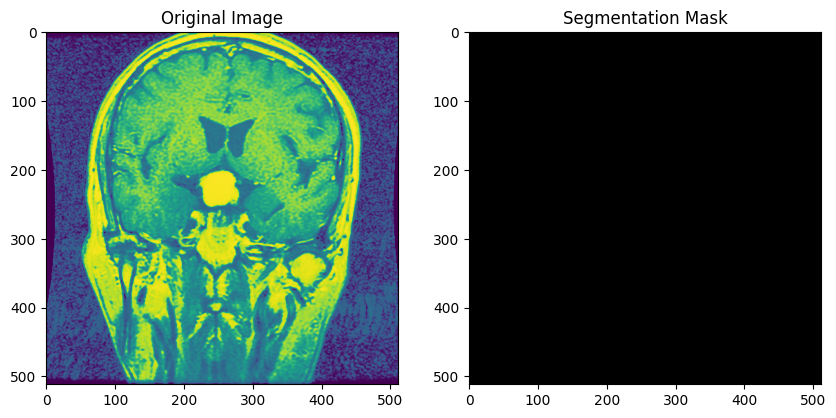

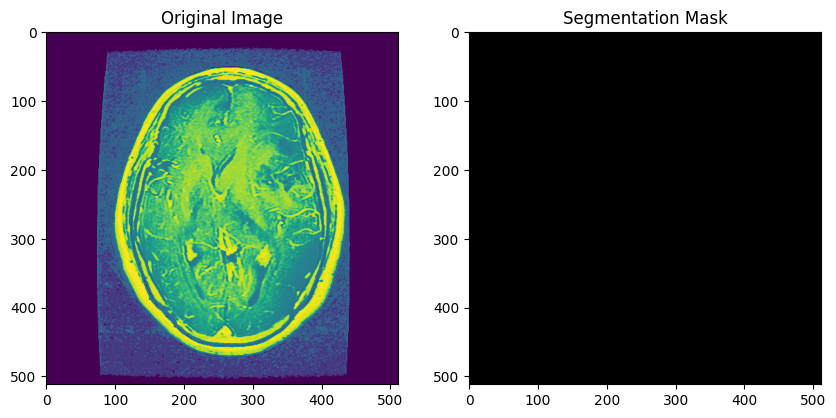

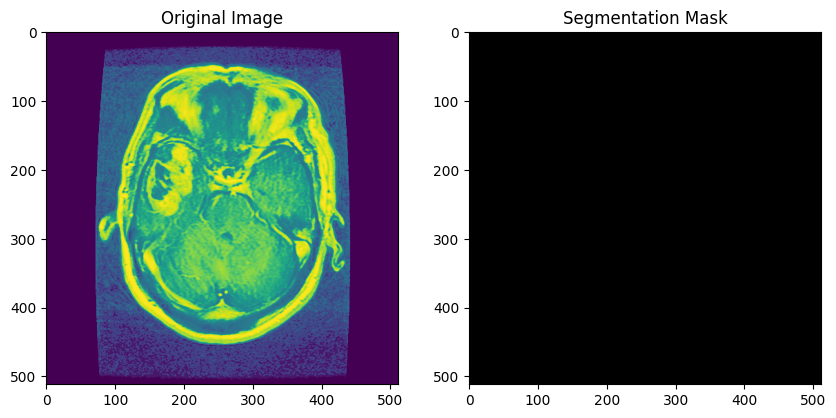

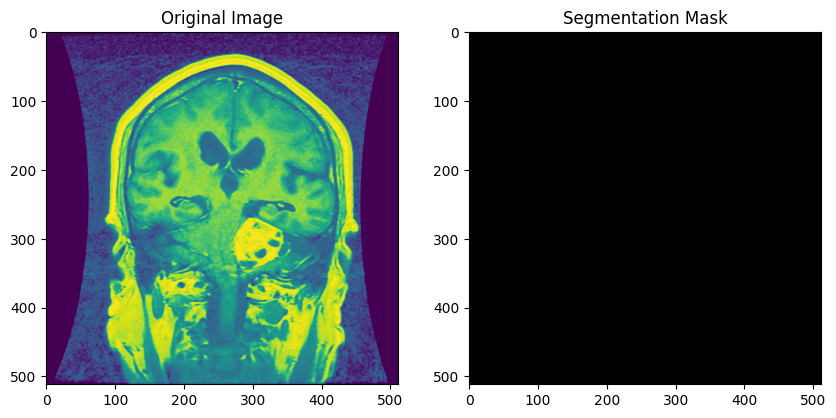

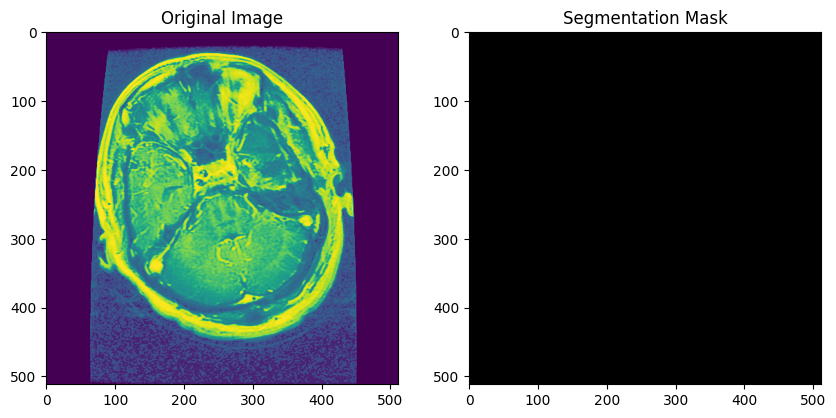

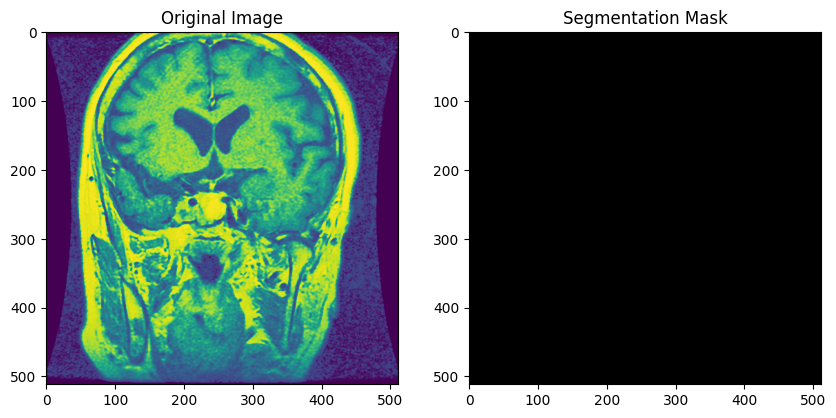

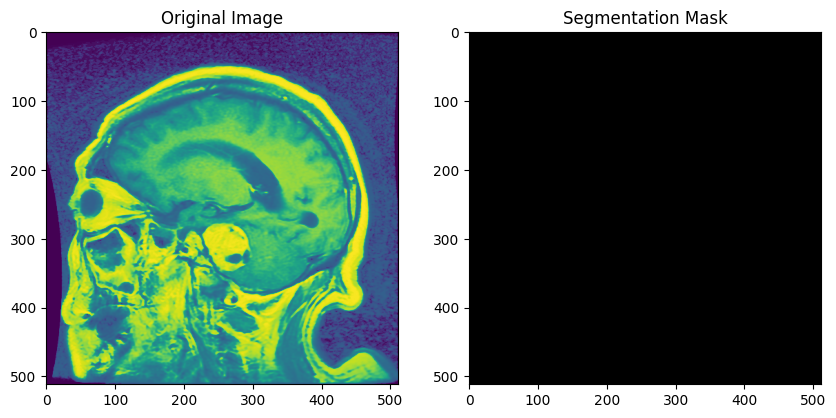

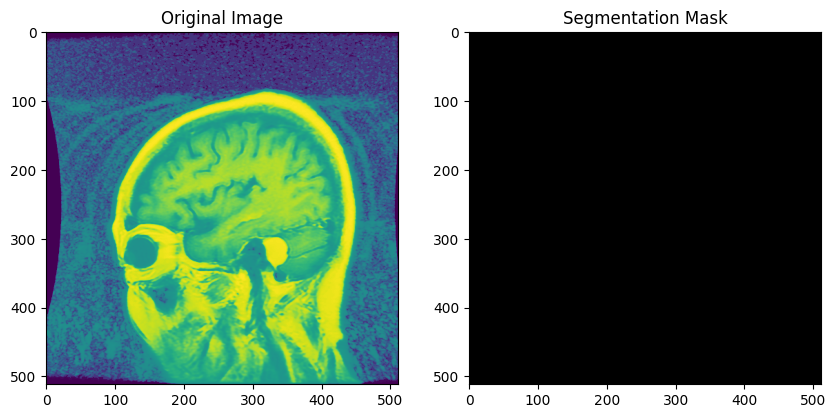

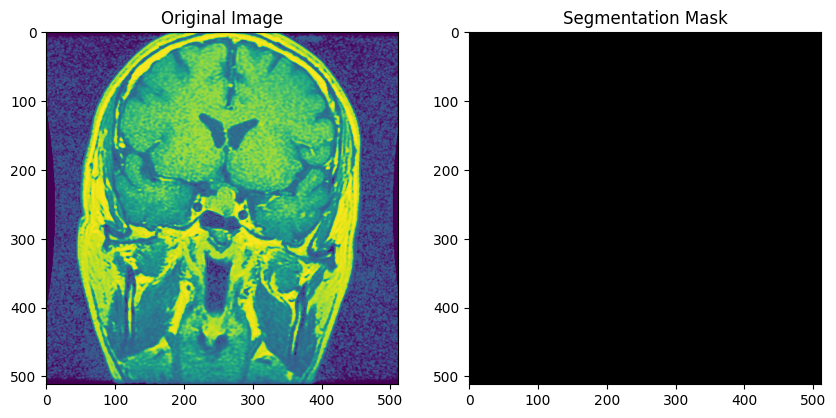

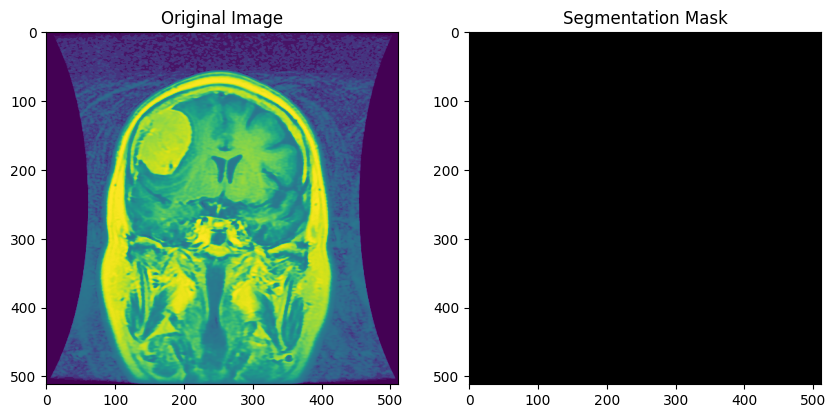

In [45]:
# visualize results for a subset of images and save all plots
predictions = model.predict(images)
subset_size = 10  # for example, change this to how many images you want to display at a time

# save ALL images to a folder
save_dir = "/Users/elizabethnemeti/Desktop/UNET_braintumor_results" # local
# add cluster pathname
os.makedirs(save_dir, exist_ok=True) # Create the directory if it does not exist

# Display and save a subset of images
for i in range(len(images)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    
    axes[0].imshow(images[i])
    axes[0].set_title('Original Image')
    
    axes[1].imshow(predictions[i], cmap='gray')  # Assuming the model outputs a single-channel binary mask
    axes[1].set_title('Segmentation Mask')

    # Save the current figure
    fig.savefig(os.path.join(save_dir, f'image_{i}_prediction.png'))

    # Only show the figure if it's in the subset we want to display
    if i < subset_size:
        plt.show()
        
    plt.close(fig) # Close the figure to free memory